# 1.10 Stepik ML contest

In [ ]:
import pandas as pd
import numpy as np

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
events_data = pd.read_csv('event_data_train.zip', compression='zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


## Валидация данных

Перед тем как начать работу с датасетом, важно убедиться, что он содержит корректные данные и в каких-то столбцах нет откровенно невалидных данных.

Давайте проверим уникальные значения в столбце action.

In [7]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Давайте создадим ещё одну колонку, в которой значение из колонки timestamp будет переведено в формат даты.

Это удобно для группировки по дням, месяцам и т.д.

In [8]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [9]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [10]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [11]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [12]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [ ]:
Давайте добавим колонку, которая будет просто являться днём.

In [13]:
events_data['day'] = events_data.date.dt.date

In [14]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Теперь у нас есть 3 поля, содержащих информацию о датах: timestamp, date и day. Теперь мы можем построить график активности студентов за всё это время и посмотреть на наши данные и увидеть некоторую историю.

Давайте посчитаем сколько уникальных пользователей было ежедневно.

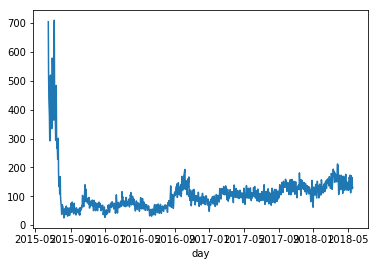

In [21]:
events_data.groupby('day').user_id.nunique().plot()

Чтобы избежать наложения значений, отмеченных на оси x, друг на друга можно воспользоваться надстройкой графика в seaborn.

In [22]:
sns.set(rc={'figure.figsize': (9, 6)})

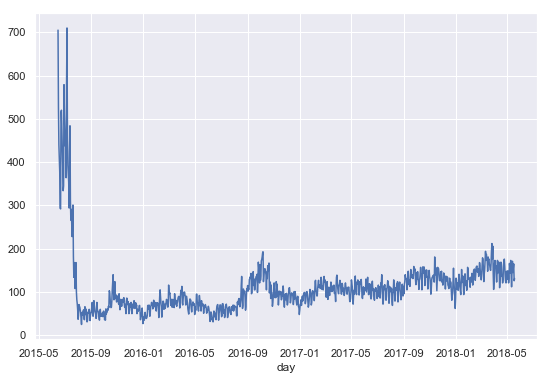

In [23]:
events_data.groupby('day').user_id.nunique().plot()

Посмотрим, как распределены пользователи по количеству баллов, набранных за курс.

Сейчас мы сделаем всё бесхитростно - для каждого пользователя (без учёта даты начала его работы с курсом) посчитаем число пройденных степов и построим распределение.

Это сейчас важно для понимания распределения данных, нет ли в нём ошибок.

**Внимание: неправильное решение**

Отберём все события, у которых action = passed, далее сгруппируем их по пользователю и посчитаем число степов с событие passed.

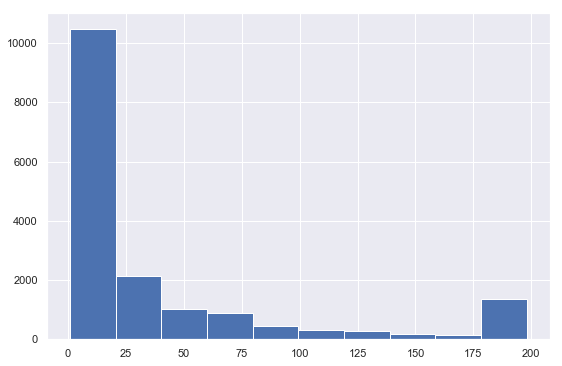

In [28]:
events_data[events_data.action == 'passed'] \ 
    .groupby('user_id', as_index=False) \ 
    .agg({'step_id': 'count'}) \ 
    .rename(columns={'step_id': 'passed_steps'}) \ 
    .passed_steps.hist()

Но при таком подходе на самом первом этапе - фильтрации по passed мы могли потерять довольно много важной информации.

Может быть у нас нет юзеров, не прошедших ни одного степа. А может быть таких юзеров тысячи, а мы взяли и выкинули их.

И это интересный и важный момент - нужно быть внимательным на каждом этапе, иначе можно сильно ошибиться в самом начале пути!

Нужно следить за всем происходящим на каждом аналитическом этапе и постоянно себя валидировать.

Если у нас было N уникальных пользователей на самом первом этапе - на каждом следующем этапе проверяйте, что число уникальных пользователей не изменилось. Что мы не потеряли никого по пути.

То есть всегда нуно делать валидирующие отметки, которые покажут, что мы ничего не потеряли при мердже данных или агрегации.

Так как ошибка не синтаксическая, то всё будет работать, но результат будет совершенно неправильным, поскольку часть данных мы просто проигнорировали.

Интересно, а как же при агрегации учесть тех эзеров, у которых 0 событий passed, но при агрегации нам бы хотелось не выкинуть их, а поставить им 0.

Для проверки мы могли бы взять минимально значение для нашего агрегированного результата:

In [30]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.min()

1

Интуитивно понятно, что у нас могут быть пользователи, не завершившие не один шаг. Поэтому уже это должно было бы нас насторожить.

Давайте воспользуемся функцией, часто использующейся для агрегации - pivot таблицы. 

## Верное решение

Pivot таблица принимает аргументы:
+ index - колонка, которую мы будем использовать как индексы
+ columns - какие колонки нам нужны
+ values - то, что мы заполним или с какими значениями мы будем работать в агрегационной функции
+ aggfunc - агрегационная функция, которую мы будем использовать

Pivot таблица развернет данные таким образом, что колонками будут различные значения в колонке action исходного датафрейма. И в них будет число степов, пройденных с этой меткой.

In [32]:
events_data.pivot_table(index='user_id', \
                        columns='action', \ 
                        values='step_id', \ 
                        aggfunc='count', \ 
                        fill_value=0).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Теперь у нас для каждого user_id есть его count'ы степов, которые были со значениями action:
+ discovered
+ passed
+ started_attempt
+ viewed

Самый первый user открыл одн степ, посмотрел на него и больше ничего с ним не делал. И у него passed=0.

Единственное, обратите внимание, что получилась довольно сложная структура датасета. 

Поэтому после применения pivot таблицы может быть удобно сделать сброс индекса

In [34]:
events_data.pivot_table(index='user_id', \
                        columns='action', \
                        values='step_id', \
                        aggfunc='count', \
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Здесь было бы достаточно удобно взять для каждого юзера колонку discovered и построить по ней гистограмму.

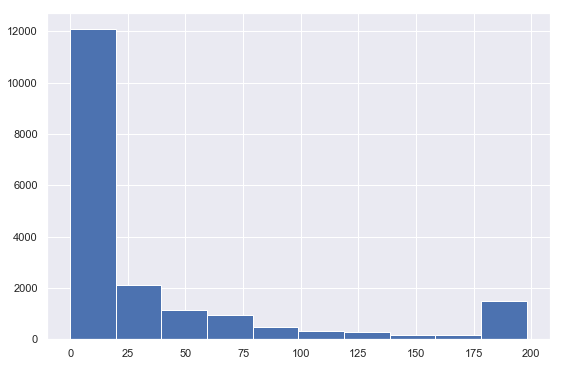

In [35]:
events_data.pivot_table(index='user_id', \
                        columns='action', \
                        values='step_id', \
                        aggfunc='count', \
                        fill_value=0).reset_index().discovered.hist()

Если вспомнить гистограмму из неправильного решения, то количество юзеров в первом столбце было существенно меньше.. Теперь же мы их учли.